In [22]:

import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import seaborn as sns

#activate high interaction shell so print() is not necessary to show output. https://stackoverflow.com/questions/31764006/ipython-notebook-display-every-line-output-without-print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 150)

In [23]:
#Basic Functions
def speed_cog_diff(df):
    df2 = df.copy()
    # Calcular la diferencia de velocidad
    df2['speedDiff-1'] = df2['Speed'].diff(periods=1).fillna(0)
    df2['speedDiff+1'] = df2['Speed'].diff(periods=-1).fillna(0)
    # Calcular la diferencia de cog entre las posiciones siguientes
    df2['cogDiff'] = df2['CourseCorrected'].diff().fillna(0)
    # Eliminar filas con valores faltantes
    df2 = df2.dropna()
    # Ajustar valores de cogDiff que superan los 180 grados
    df2.loc[df2['cogDiff'] > 180, 'cogDiff'] -= 360
    df2.loc[df2['cogDiff'] < -180, 'cogDiff'] += 360
    # Tomar el valor absoluto de cogDiff
    df2['cogDiff'] = df2['cogDiff'].abs()
    return df2

def unify_operations(df):
    df2 = df.copy()
    # Convertir la columna 'Operation' a factor y quitar espacios
    df2['Operation'] = df2['Operation'].str.replace(" ", "").astype('category')
    # Mapear categorías específicas a valores unificados
    operation_mapping = {
        'Copeig': 'C',
        'Recollidaxarxa': 'C',
        'Tancamentxarxa': 'C',
        'Calada': 'C',
        'Tornadaport': 'N',
        'Sortidaport': 'N',
        'Busqueda': 'N',
        'Navegacio': 'N',
        'Acumulacio': 'A'
    }
    df2['Operation'] = df2['Operation'].map(operation_mapping)
    # Convertir la columna 'Operation' a factor
    df2['Operation'] = df2['Operation'].astype('category')
    return df2

In [24]:
#2. get VMS classified data
vmsOp = pd.read_csv('data/vmsOp.csv')
vmsOp = gpd.GeoDataFrame(vmsOp, crs='EPSG:4326', geometry=vmsOp['geom'].apply(shapely.wkt.loads))

#3. Unify operations and calculate speed and cog diffs
vmsOp2 = unify_operations(vmsOp)
vmsOp2 = speed_cog_diff(vmsOp2)
len(vmsOp2)


2136

In [25]:
#4. Calculate buffer arround each point by fishing day (TrackCode variable)
n = 0
radius=500
vmsOp2['bufferGeom'] = vmsOp2.to_crs(25831).buffer(radius).to_crs(4326)
df = pd.DataFrame()
for tk in vmsOp2.TrackCode.unique():
    n = n + len(vmsOp2.loc[vmsOp2['TrackCode']==tk])
    tkPoints = vmsOp2.loc[vmsOp2['TrackCode']==tk]
    tkPointsJoined = tkPoints.set_geometry('bufferGeom').sjoin(tkPoints[['geometry']])
    tkPointsBufferCount = pd.DataFrame(tkPointsJoined.groupby(tkPointsJoined.index)['index_right'].count()).rename(columns={'index_right':'bufferCount'})
    #df = pd.concat([df, tkPoints.join(tkPointsBufferCount-1)])
    df = pd.concat([df, tkPoints.join(tkPointsBufferCount)])
vmsOp2 = df
vmsOp2.to_csv('data/vmsOp2.csv', index=False)

2136

<AxesSubplot: xlabel='Operation', ylabel='Speed'>

<AxesSubplot: xlabel='Operation', ylabel='CourseCorrected'>

<AxesSubplot: xlabel='Operation', ylabel='speedDiff-1'>

<AxesSubplot: xlabel='Operation', ylabel='speedDiff+1'>

<AxesSubplot: xlabel='Operation', ylabel='cogDiff'>

<AxesSubplot: xlabel='Operation', ylabel='DayTime2'>

<AxesSubplot: xlabel='Operation', ylabel='bufferCount'>

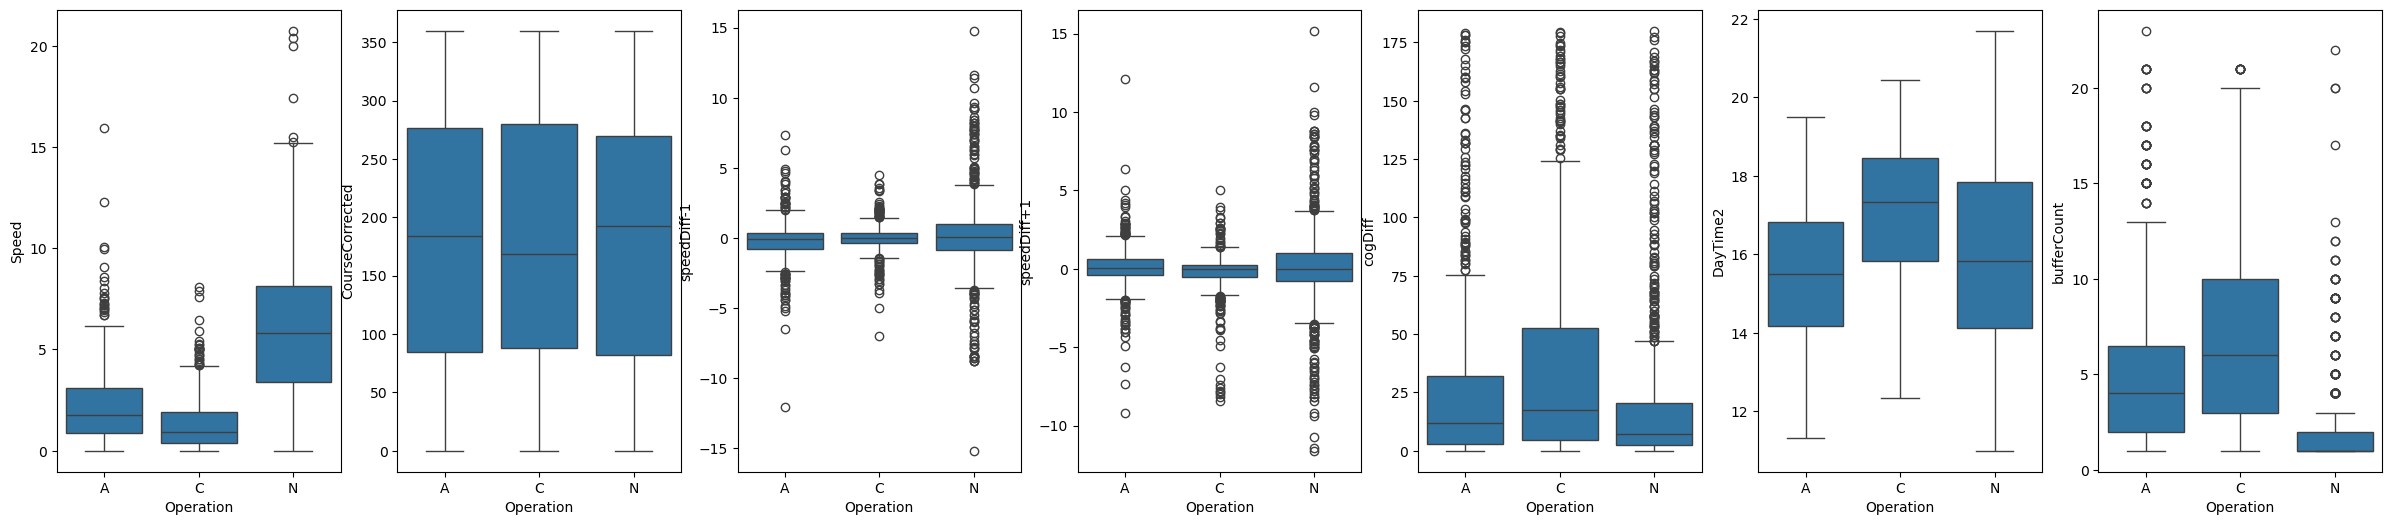

In [26]:
#5. Visually explore dataset
plotdf = vmsOp2.loc[(vmsOp2.Operation.notna())]
len(plotdf) 
fig, axs = plt.subplots(ncols=7, figsize=(30,6))
#sns.scatterplot( x='Course', y='Speed', hue='Operation', data=plotdf, ax=axs[0])
sns.boxplot(x='Operation', y='Speed', data=plotdf, ax=axs[0])
sns.boxplot(x='Operation', y='CourseCorrected', data=plotdf, ax=axs[1])
sns.boxplot(x='Operation', y='speedDiff-1', data=plotdf, ax=axs[2])
sns.boxplot(x='Operation', y='speedDiff+1', data=plotdf, ax=axs[3])
sns.boxplot(x='Operation', y='cogDiff', data=plotdf, ax=axs[4])
sns.boxplot(x='Operation', y='DayTime2', data=plotdf, ax=axs[5])
sns.boxplot(x='Operation', y='bufferCount', data=plotdf, ax=axs[6])